In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd
from datetime import datetime


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'batsong_segmented'

In [5]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-11-12_21-07-56'

In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [8]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=2000,
    mel_upper_edge_hertz=60000,#120000,
    butter_lowcut = 500,
    butter_highcut = 120000,
    ref_level_db = 20,
    min_level_db = -40,
    mask_spec = True,
    win_length_ms = 0.5,
    hop_length_ms = 0.05,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 11193 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 30793 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 55993 tasks      | elapsed:   13.4s


[Parallel(n_jobs=-1)]: Done 83823 out of 83823 | elapsed:   17.7s finished


In [10]:
dataset.sample_json

OrderedDict([('fid', 166697),
             ('Treatment ID', 17),
             ('Recording channel', 1),
             ('Recording time', '2013-01-16 08:06:24'),
             ('indvs',
              OrderedDict([('-210',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times',
                                                        [0.203, 0.372]),
                                                       ('end_times',
                                                        [0.279,
                                                         0.5065])]))]))])),
             ('species', 'Rousettus aegyptiacus'),
             ('common_name', 'Egyptian fruit bat'),
             ('samplerate_hz', 250000),
             ('original_wav',
              '/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/raw/batsong/zip_contents/files212/130116080549387242.WAV'),
             ('length_s', 1.543488),
             ('wav_loc',
      

#### Create dataset based upon JSON

In [11]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 1

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="syllables",
            dict_features_to_retain = ['context'],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 191 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1173 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 2573 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 4373 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 6573 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 9173 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 12173 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 15573 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 19373 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 23573 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 28173 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 33173 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 38573 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 44373 ta

[Parallel(n_jobs=-1)]: Done 83823 out of 83823 | elapsed:  2.3min finished


423043

In [13]:
syllable_df[:3]

start_time  end_time  indv  indvi      context                 key
0       0.203    0.2790  -210      0  Threat-like  130116080549387242
1       0.372    0.5065  -210      0  Threat-like  130116080549387242
0       0.223    0.2465  -221      0     Sleeping  130303053329639859

### get audio for dataset

In [14]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_df = pd.concat( parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    ))
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2402 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3152 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4952 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 6002 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 7152 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 8402 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9752 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 11202 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 12752 tasks    

[Parallel(n_jobs=-1)]: Done 83745 out of 83745 | elapsed: 49.8min finished


423043

In [15]:
syllable_df[:3]

start_time  end_time  indv  indvi      context                 key  \
0       0.203    0.2790  -210      0  Threat-like  130116080549387242   
1       0.372    0.5065  -210      0  Threat-like  130116080549387242   
0       0.223    0.2465  -221      0     Sleeping  130303053329639859   

                                               audio    rate  
0  [-0.00059547316, -0.00022734354, -7.5086624e-0...  250000  
1  [-0.0003808931, -0.0010865084, -0.0003486699, ...  250000  
0  [0.00031099207, -0.00029851616, -0.00021561986...  250000

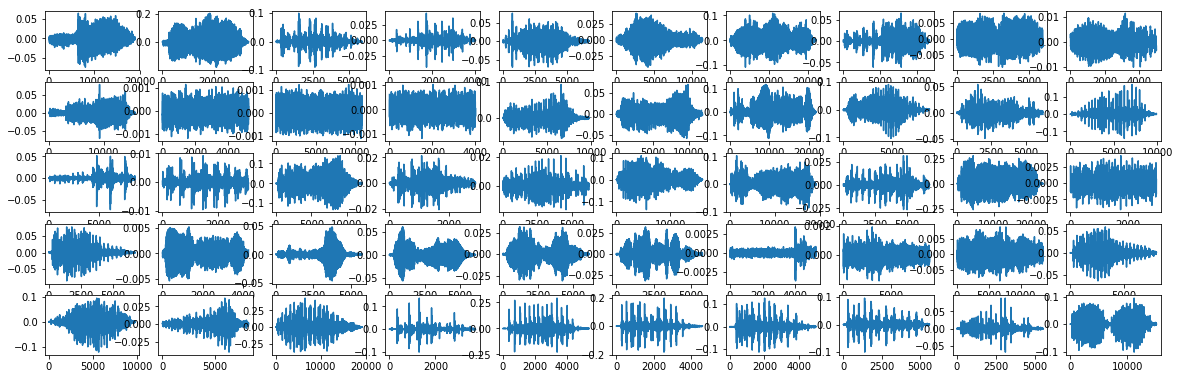

In [16]:
nrows = 5
ncols = 10
sylls = syllable_df.audio.values[:nrows*ncols]
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)

In [17]:
syllable_df['audio'] = [i/np.max(np.abs(i)) for i in tqdm(syllable_df.audio.values)]

### Create spectrograms

In [18]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [19]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'fruitbat-just_audio.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)

In [21]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllable_df.audio.values, syllable_df.rate.values),
            total=len(syllable_df),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 4336 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 6536 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 9136 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 12136 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 15536 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 19336 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 23536 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 28136 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 33136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 38536 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 44336 ta

[Parallel(n_jobs=-1)]: Done 422996 out of 423043 | elapsed: 18.0min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 423043 out of 423043 | elapsed: 18.0min finished


### Rescale spectrogram
- using log rescaling

In [22]:
log_scaling_factor = 4

In [23]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 8816 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 19418 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 30268 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 44218 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 61268 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 81418 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 104668 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 124122 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 138372 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154122 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 171372 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 190122 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 210372 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: 

[Parallel(n_jobs=-1)]: Done 423043 out of 423043 | elapsed:  3.1min finished


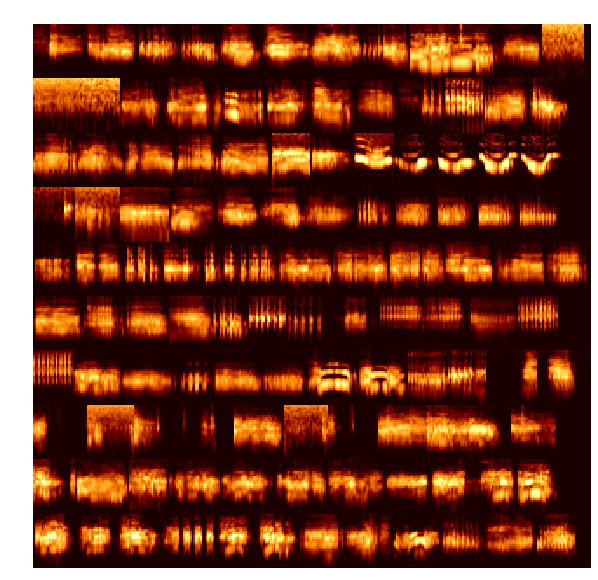

In [24]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=10)

### Pad spectrograms

In [25]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [26]:
syllable_df[:3]

start_time  end_time  indv  indvi      context                 key  \
0       0.203    0.2790  -210      0  Threat-like  130116080549387242   
1       0.372    0.5065  -210      0  Threat-like  130116080549387242   
0       0.223    0.2465  -221      0     Sleeping  130303053329639859   

                                               audio    rate  
0  [-0.008155702, -0.0031137357, -0.0010283992, 0...  250000  
1  [-0.0018828807, -0.005370971, -0.0017235909, 0...  250000  
0  [0.0031501623, -0.0030237888, -0.0021840993, 0...  250000

In [27]:
import seaborn as sns

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


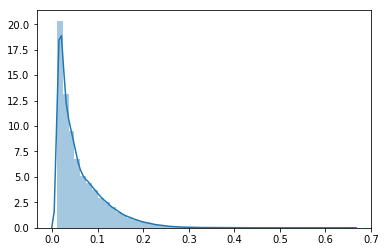

In [28]:
sns.distplot((syllable_df["end_time"] - syllable_df["start_time"]))
#plt.legend()

In [29]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 13908 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 38408 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 69908 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 108408 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 153908 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 206408 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 265908 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 332408 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 405908 tasks      | elapsed:  1.5min


[Parallel(n_jobs=-1)]: Done 423043 out of 423043 | elapsed:  1.6min finished


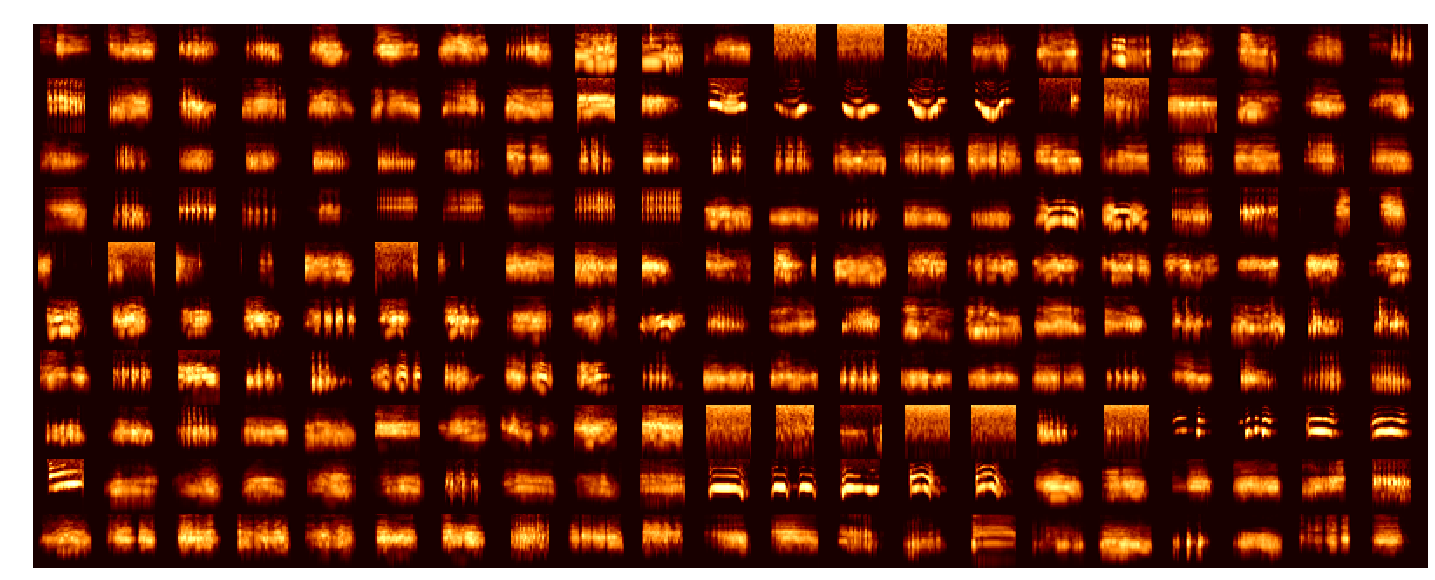

In [30]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [31]:
syllable_df['spectrogram'] = syllables_spec

In [32]:
syllable_df[:3]

start_time  end_time  indv  indvi      context                 key  \
0       0.203    0.2790  -210      0  Threat-like  130116080549387242   
1       0.372    0.5065  -210      0  Threat-like  130116080549387242   
0       0.223    0.2465  -221      0     Sleeping  130303053329639859   

                                               audio    rate  \
0  [-0.008155702, -0.0031137357, -0.0010283992, 0...  250000   
1  [-0.0018828807, -0.005370971, -0.0017235909, 0...  250000   
0  [0.0031501623, -0.0030237888, -0.0021840993, 0...  250000   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [33]:
# remove noise spectrograms
syll_shape = np.shape(syllables_spec[0])
bad_specs = np.array([np.argmax(np.sum(i, axis=1)) > ((syll_shape[0]*.9)-1) for i in syllables_spec])
print(np.sum(bad_specs))

15401


In [34]:
syllable_df = syllable_df[bad_specs==False]

In [35]:
len(syllable_df)

407642

### view syllables per indv

In [36]:
syllable_df.indv.unique()

array(['-210', '-221', '214', '-119', '111', '230', '0', '-220', '-211',
       '-215', '-216', '-208', '216', '-120', '203', '207', '-231', '228',
       '-222', '226', '211', '215', '221', '-110', '-230', '-228', '-207',
       '-109', '108', '-105', '-203', '220', '-226', '-101', '213', '102',
       '233', '-213', '116', '120', '115', '-223', '109', '119', '231',
       '204', '-225', '225', '-107', '-201', '112', '-202', '101', '-204',
       '208', '-116', '-111', '110', '113', '222', '210', '-114', '-214',
       '-102', '201', '105', '223', '205', '-205', '103', '-115', '-103',
       '107', '218', '-118', '114', '-108', '-233', '202', '-112', '-218',
       '118', '-113'], dtype=object)

In [39]:
len(syllable_df)

407642

-119 1744


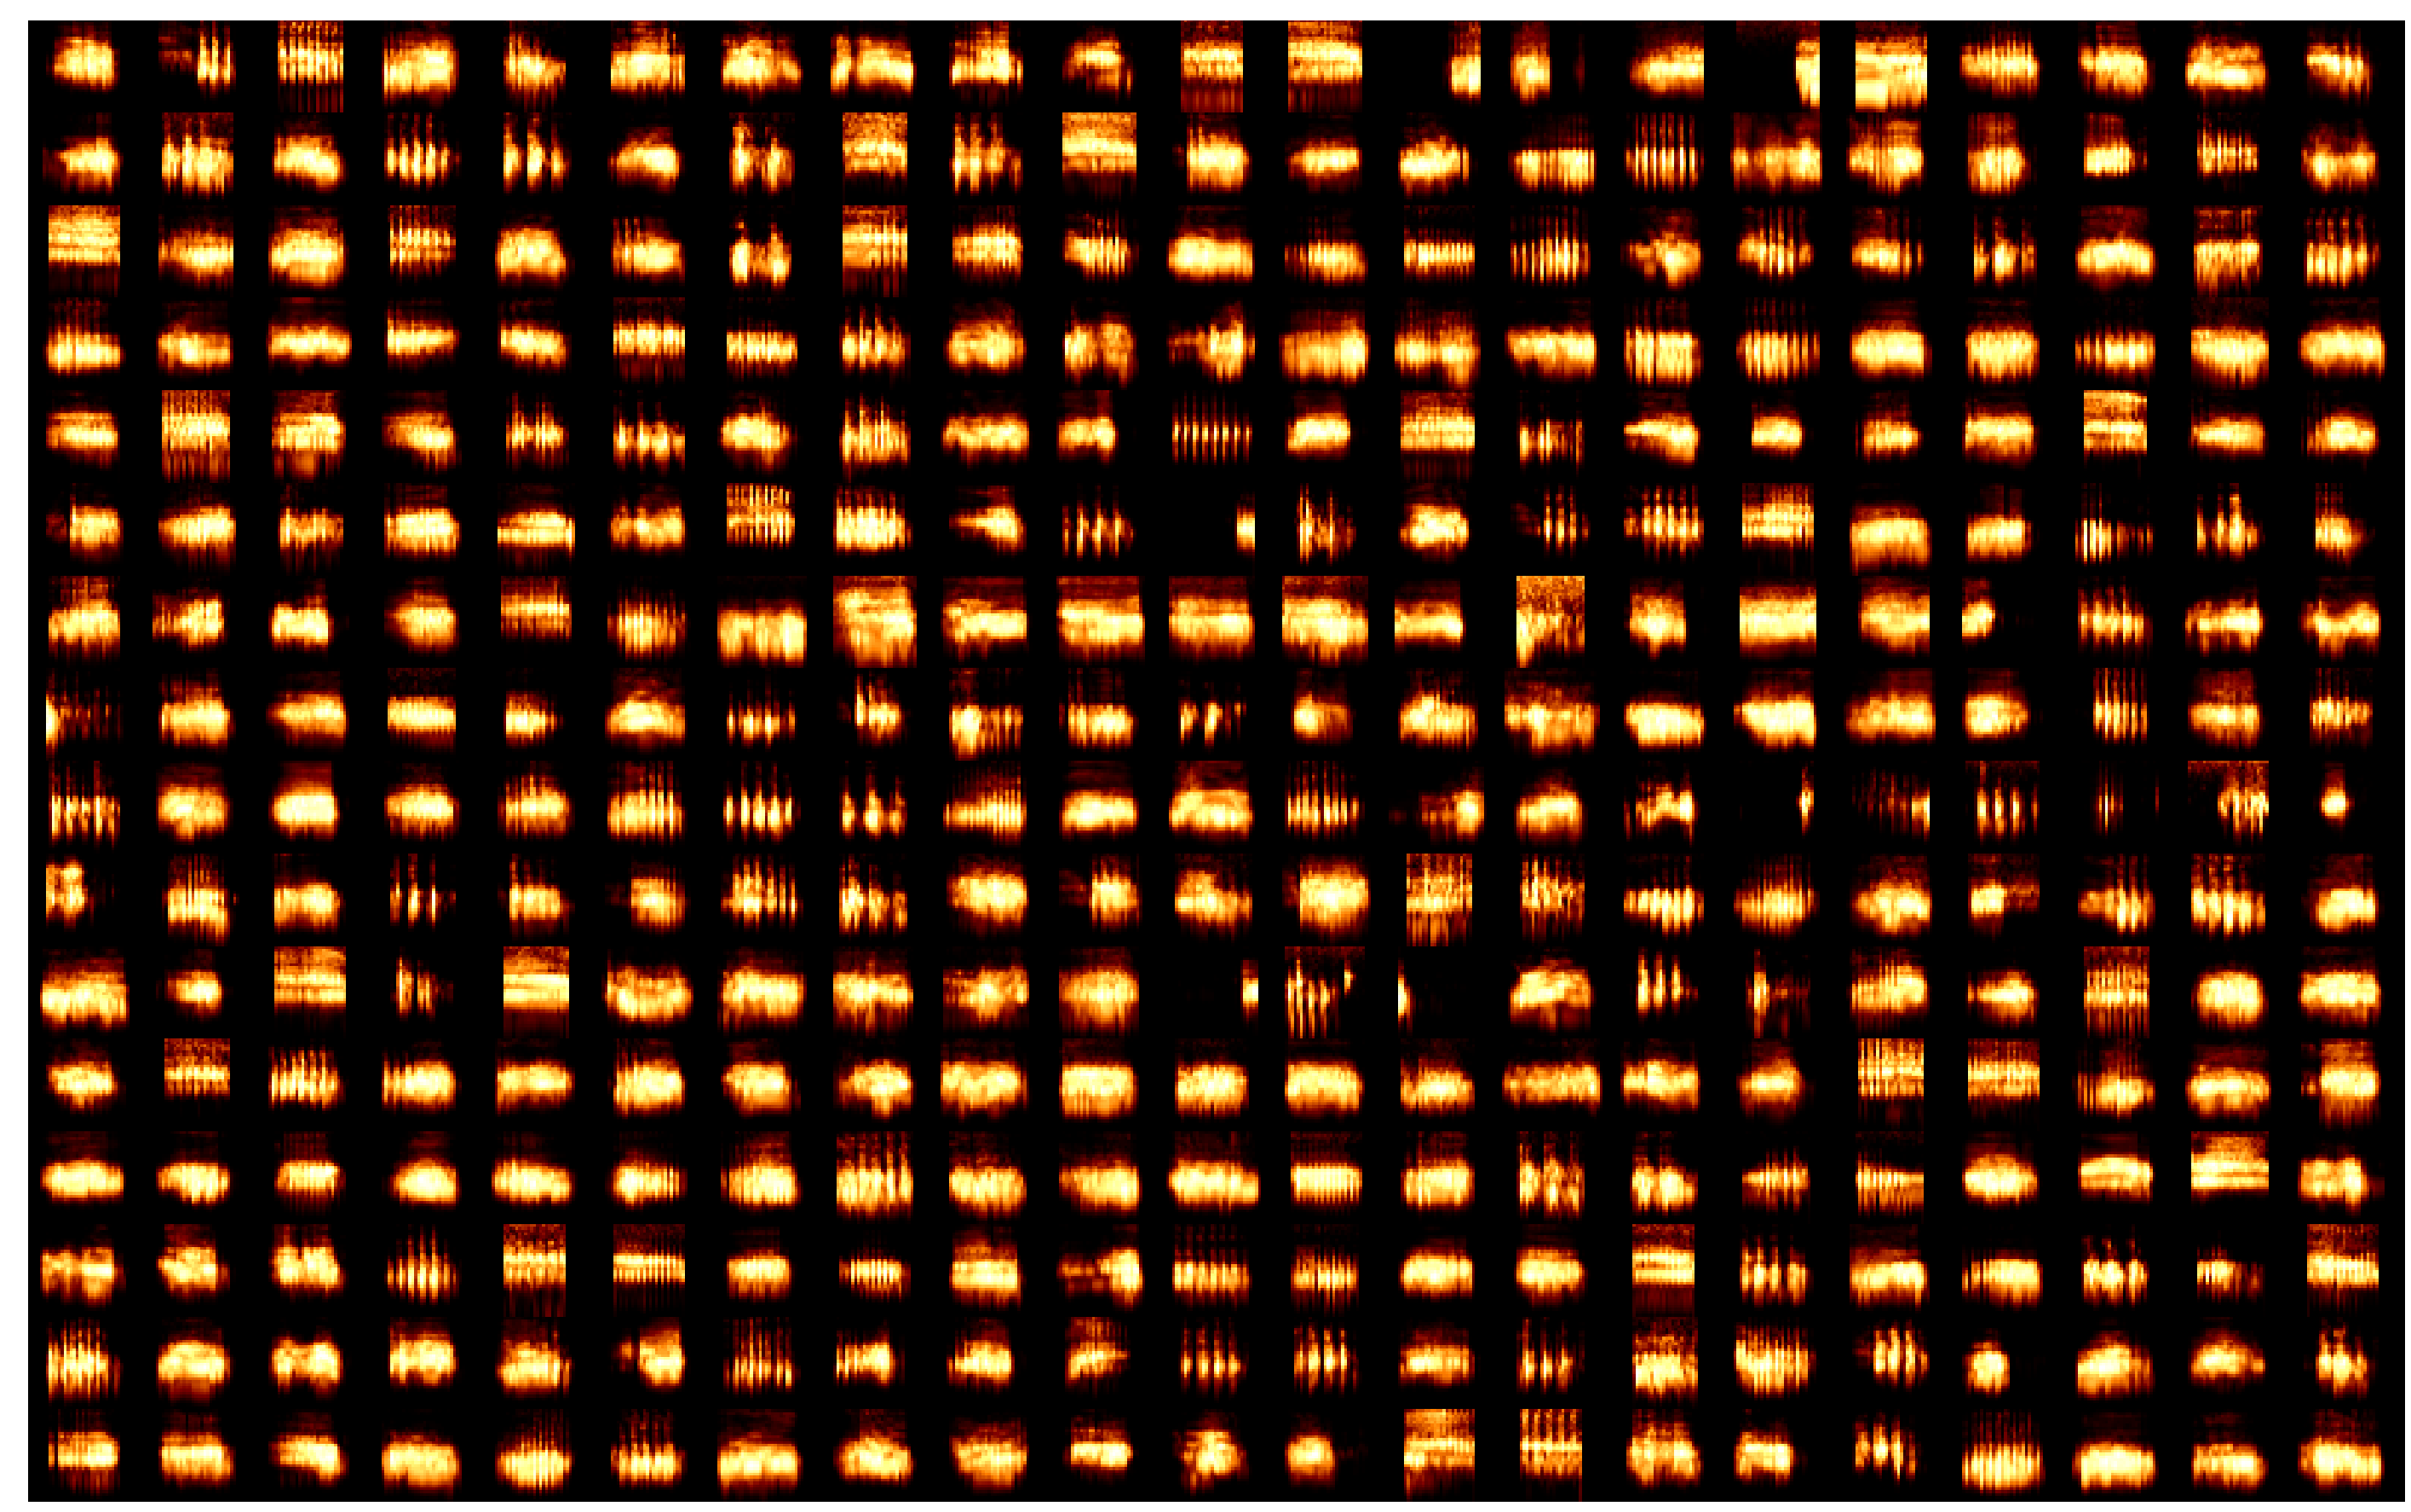

-210 8434


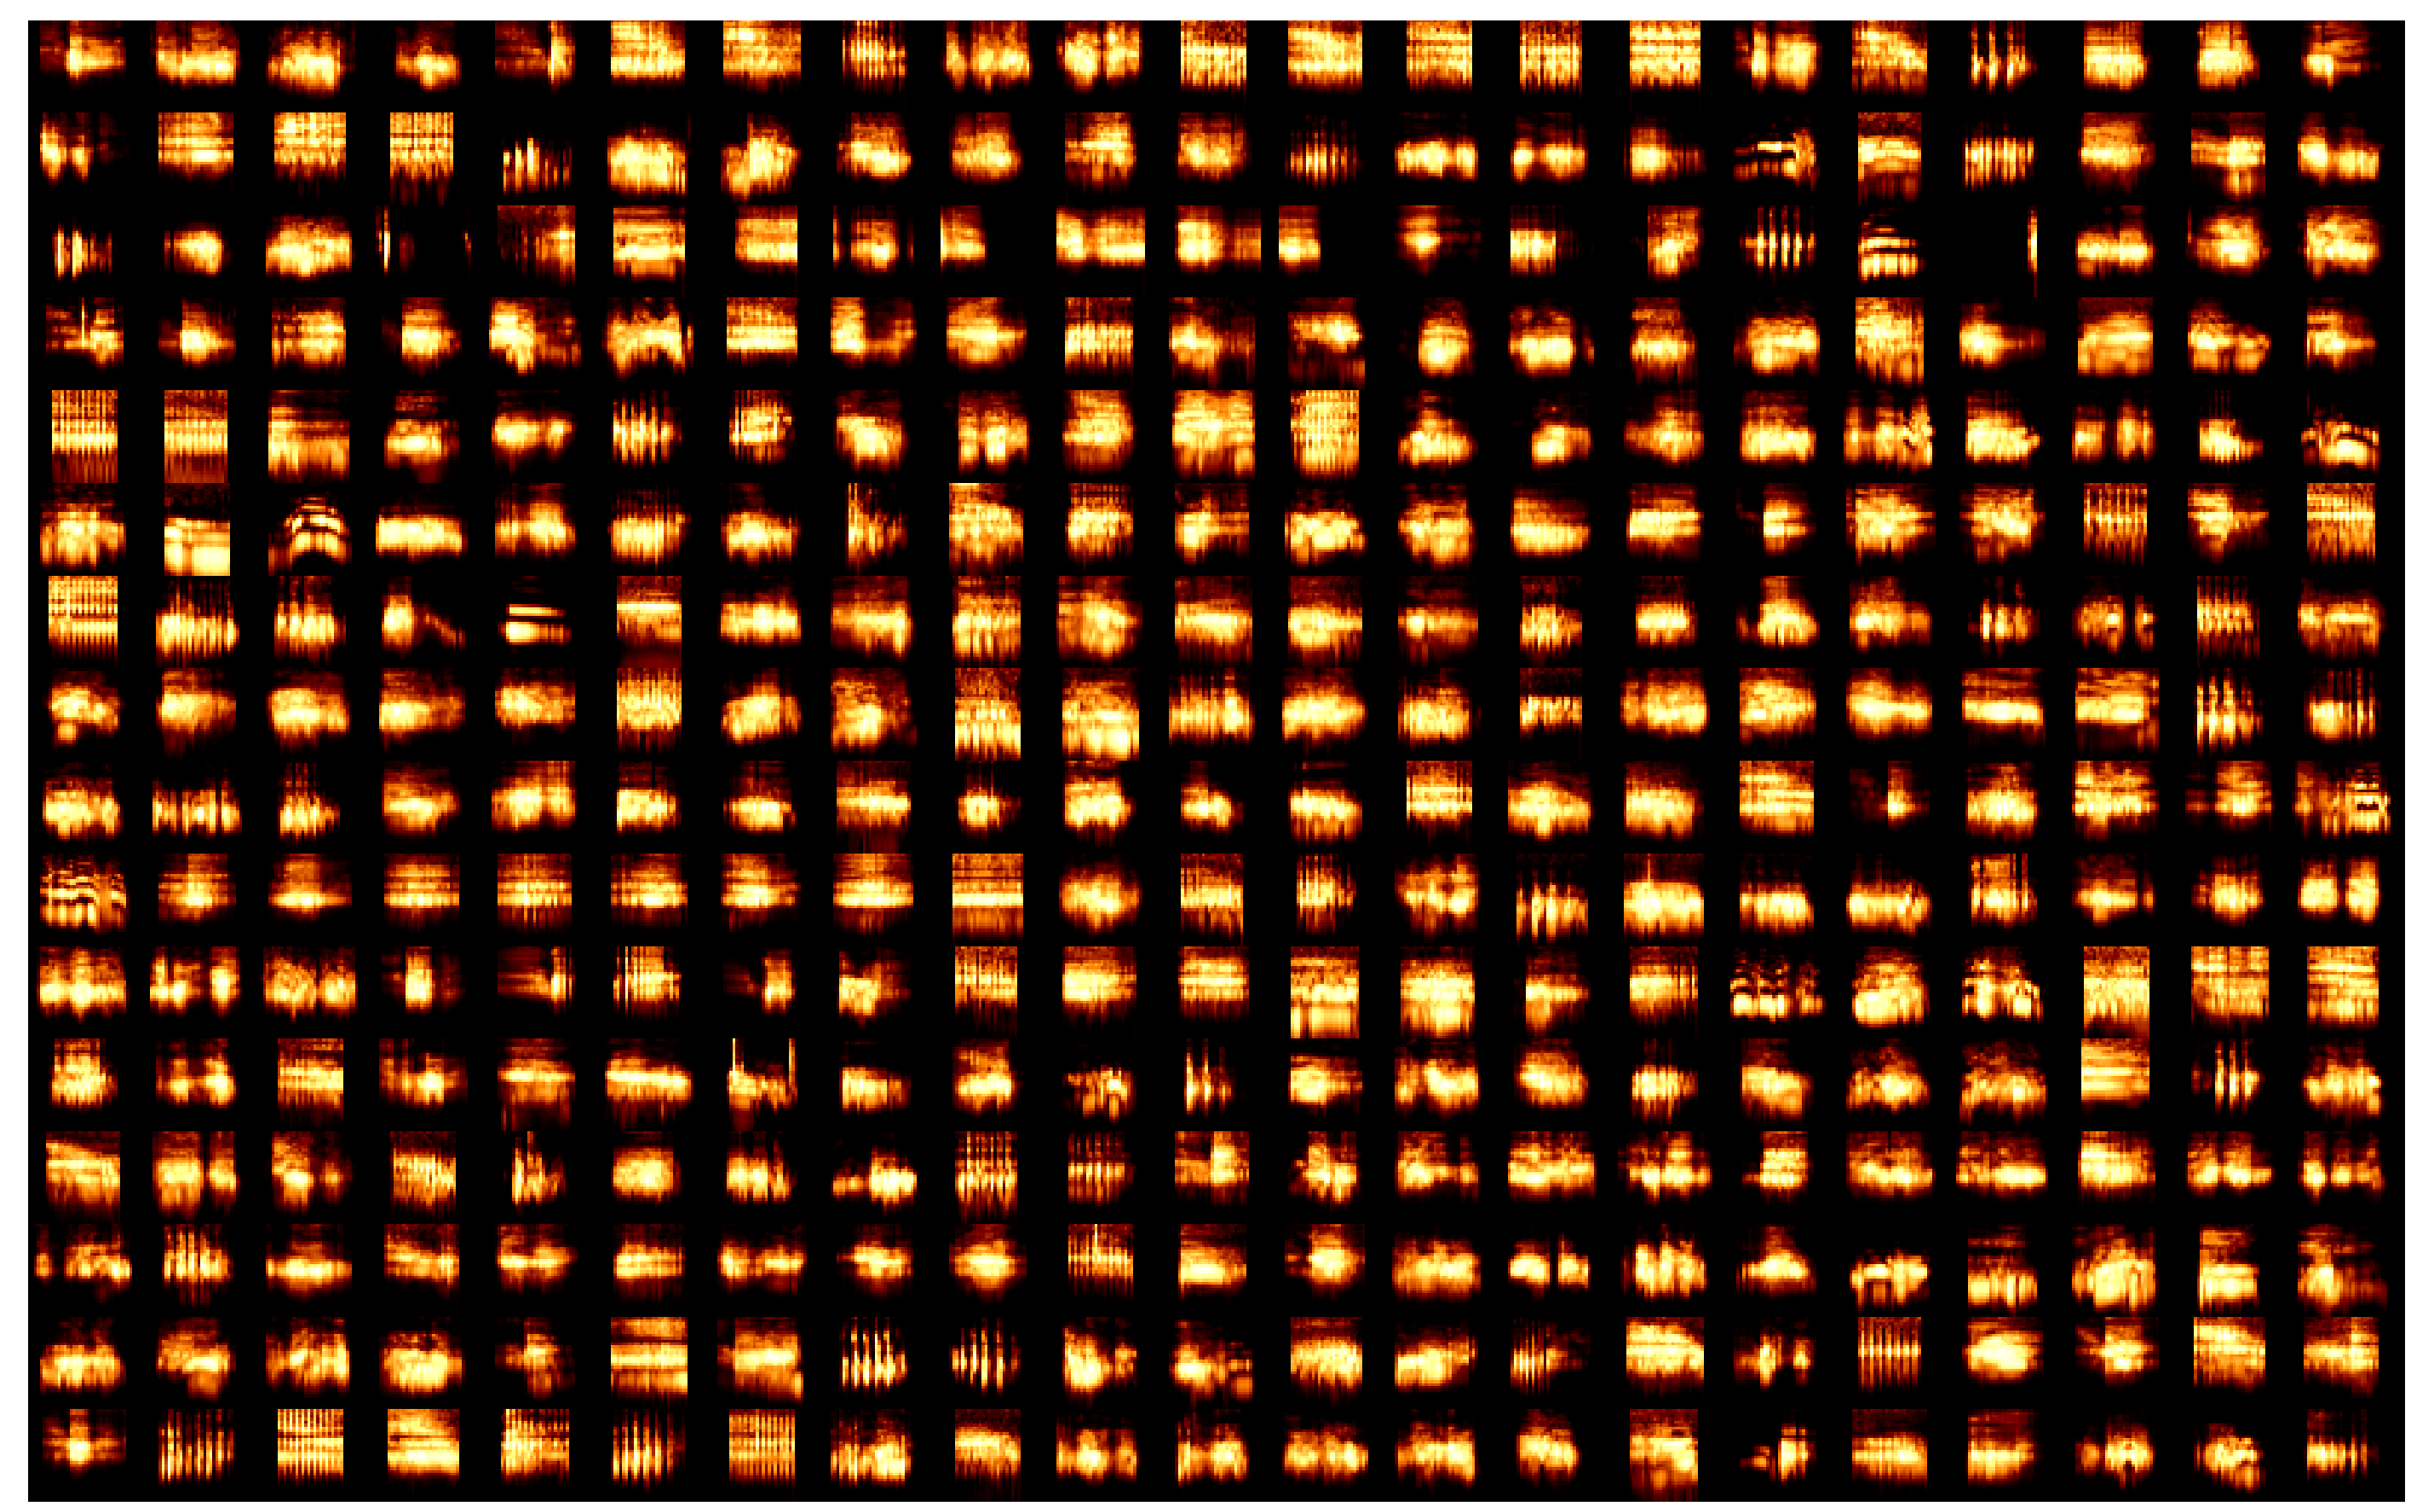

-221 8220


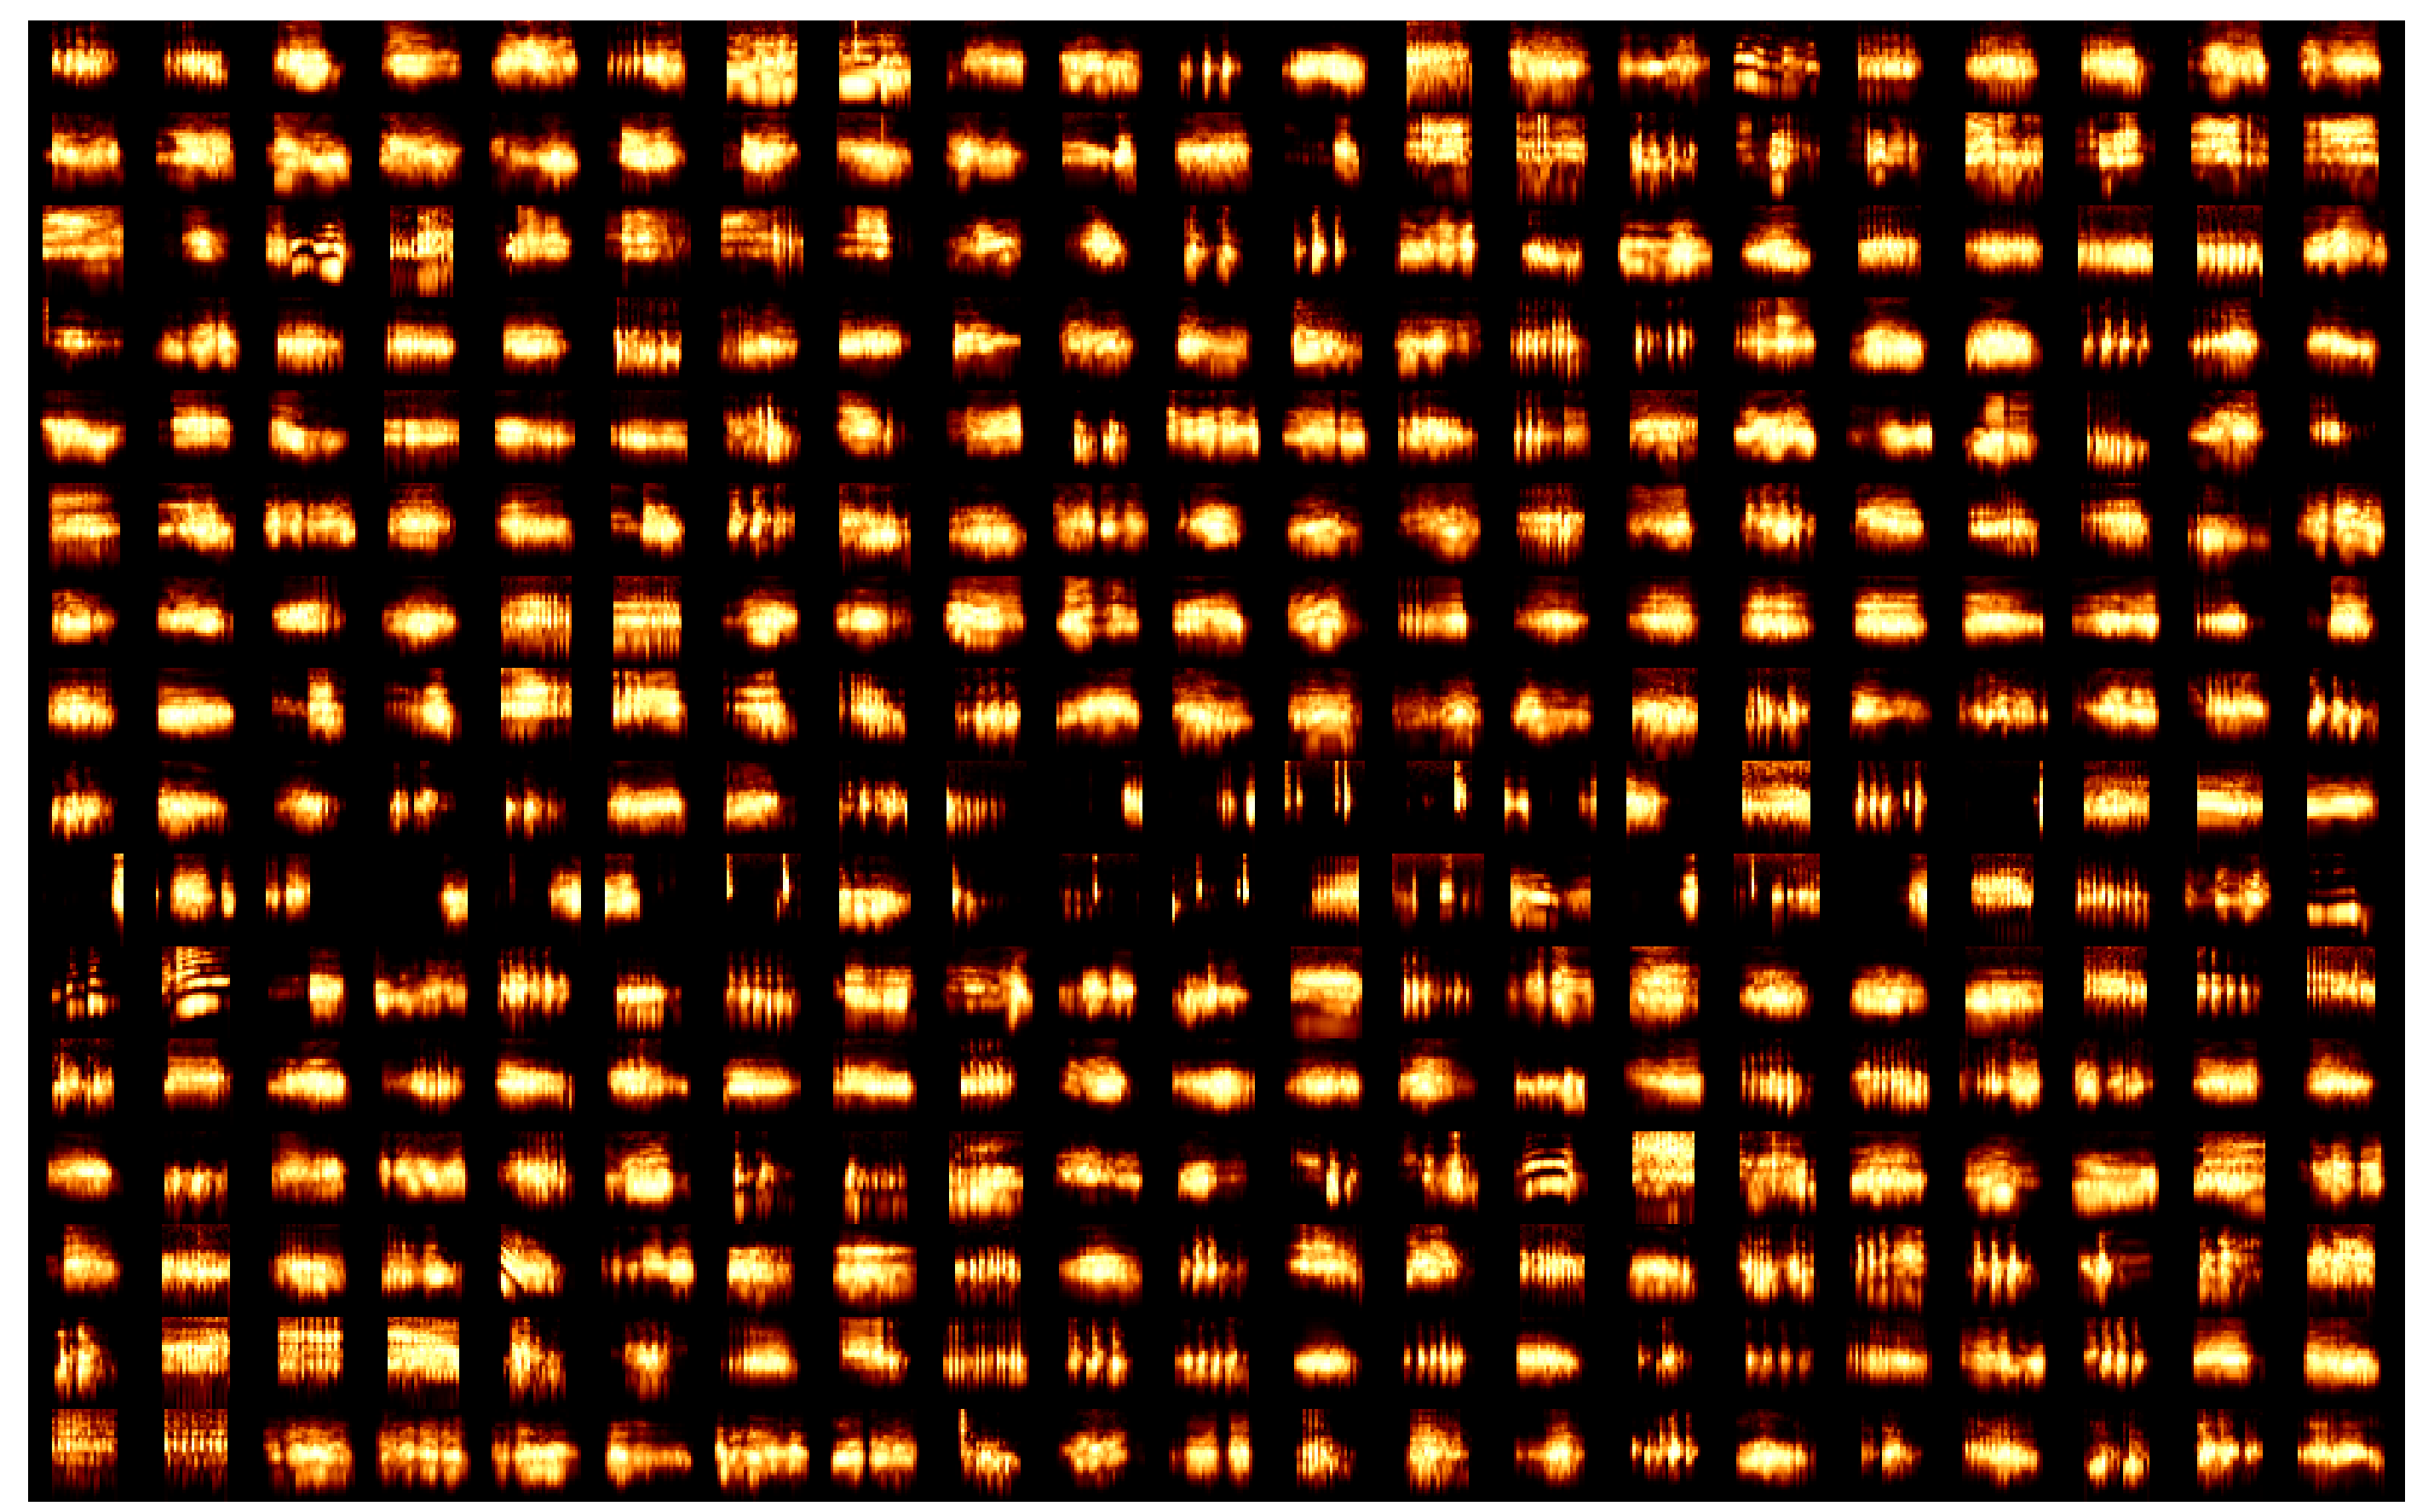

111 6011


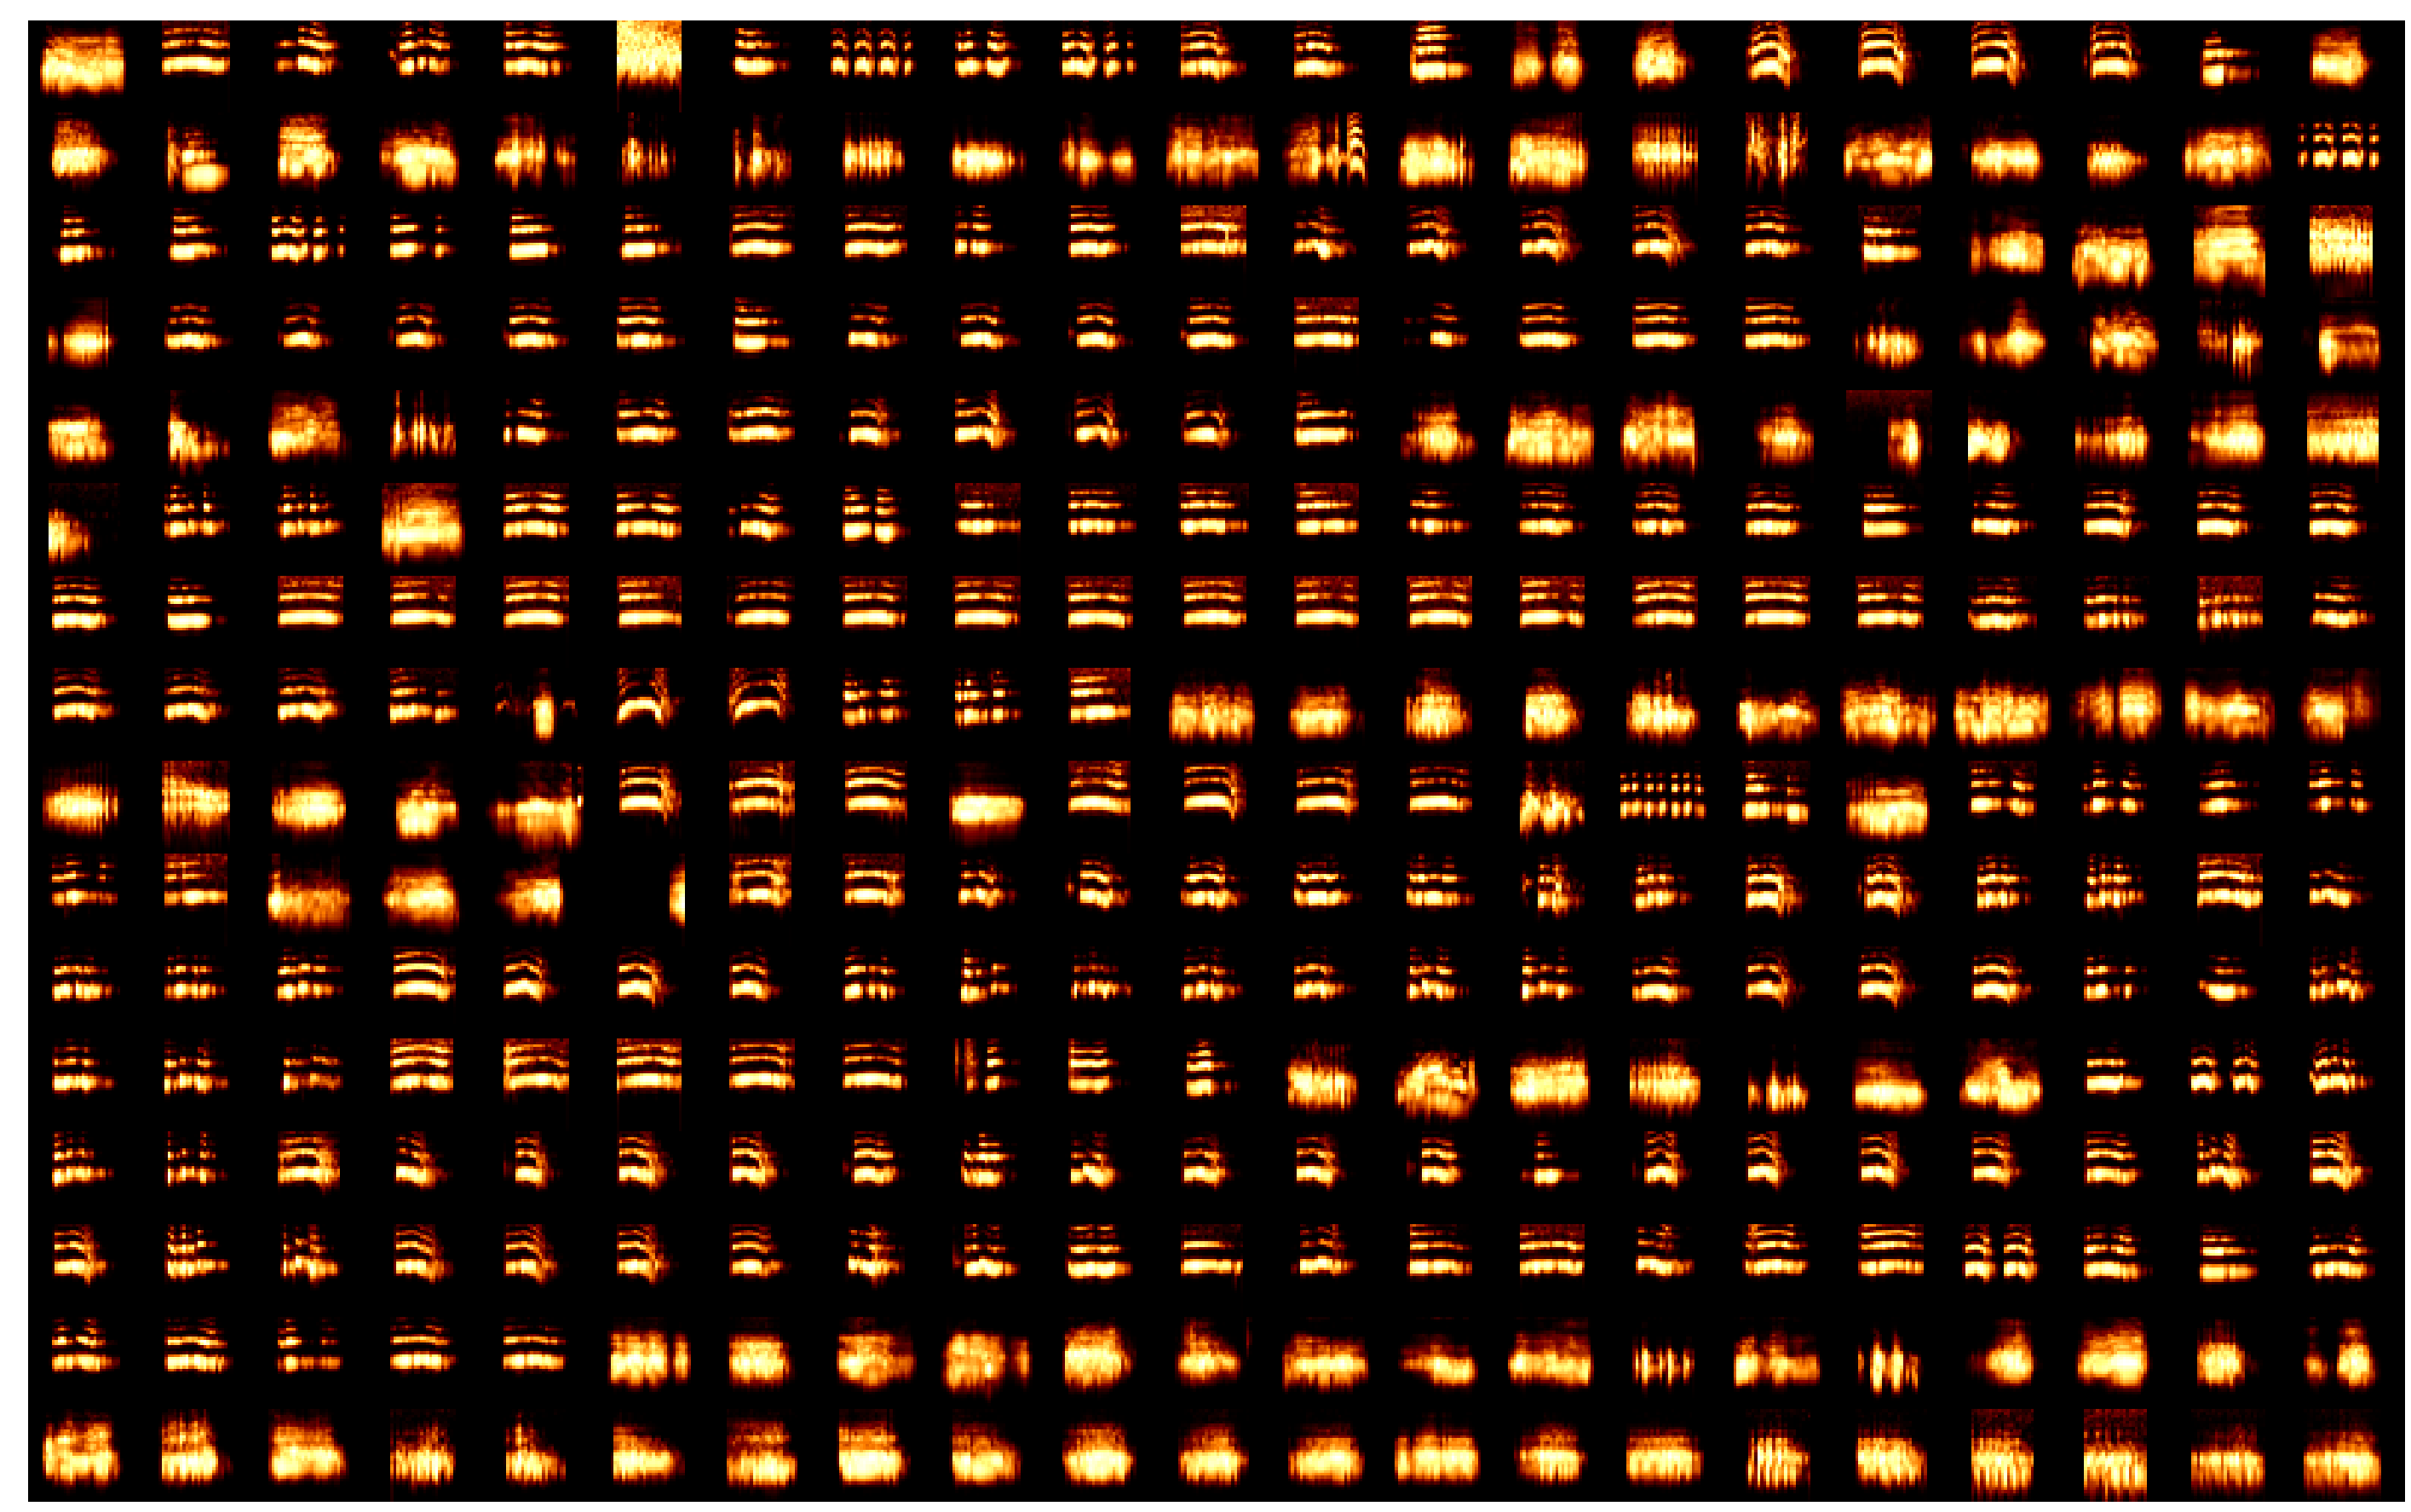

214 483


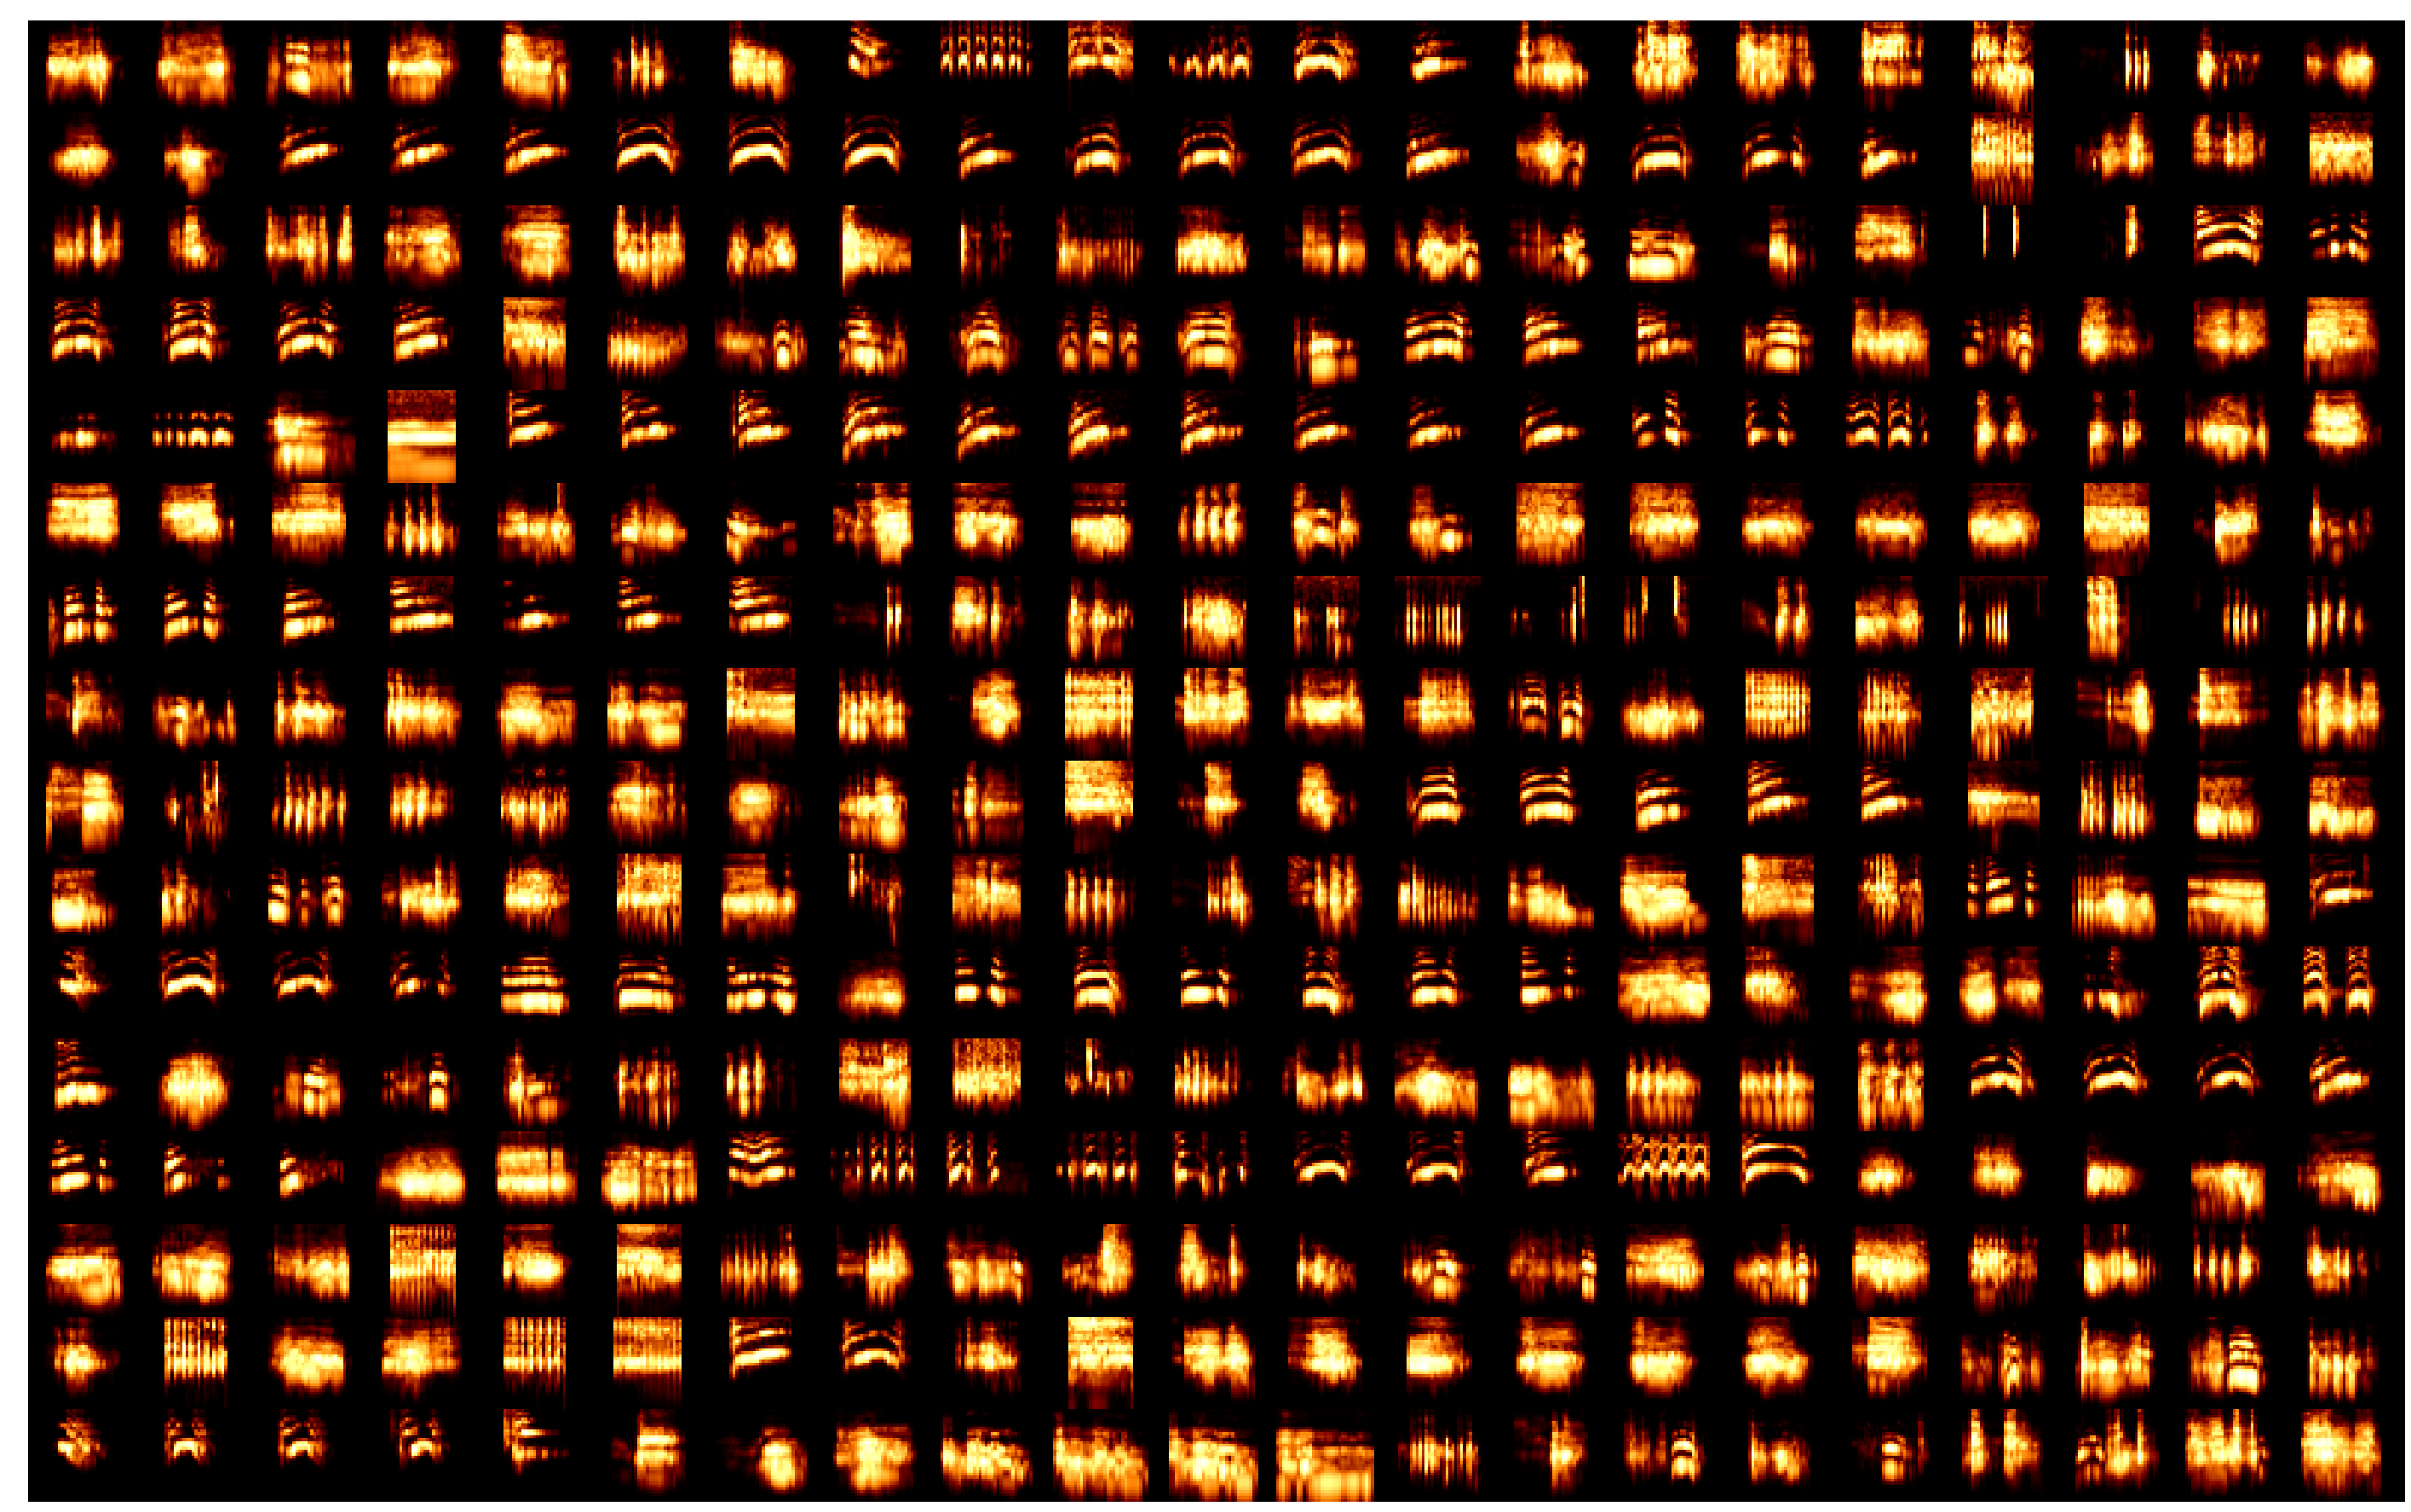

In [37]:
for indv in np.sort(syllable_df.indv.unique()[:5]):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [38]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'fruitbat.pickle'
ensure_dir(save_loc)
syllable_df.drop(columns = ['audio']).to_pickle(save_loc)